<a href="https://www.kaggle.com/code/georgeliu/imdb-text-classification-with-transformers?scriptVersionId=120104830" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## To-do's
- test_ds.train_test_split(test_size=0.5, stratify_by_column="label") [ref](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset)
- upgrade datasets to latest version
- check `label_mapping` structure
- model loading from saved dir https://discuss.huggingface.co/t/using-trainer-at-inference-time/9378/7

## 1. Set up Environment

In [1]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 547.6 kB/s eta 0:00:00


In [2]:
import os
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import evaluate
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

import torch
from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from evaluate import evaluator

seed = 168

## 2. Get and Prepare Data

In [3]:
imdb = load_dataset('imdb')
imdb

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [4]:
train_ds, test_ds = imdb['train'], imdb['test']
train_ds, test_ds

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [5]:
test_splits = test_ds.train_test_split(test_size=.5)
validation_ds, test_ds = test_splits['train'], test_splits['test']
validation_ds, test_ds

(Dataset({
     features: ['text', 'label'],
     num_rows: 12500
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 12500
 }))

In [6]:
inference_ds = imdb['unsupervised']
inference_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

In [7]:
# Sample all datasets
random_sample_size = 1000
train_ds = train_ds.shuffle(seed=seed).select(range(random_sample_size))
validation_ds = validation_ds.shuffle(seed=seed).select(range(random_sample_size))
test_ds = test_ds.shuffle(seed=seed).select(range(random_sample_size))
inference_ds = inference_ds.shuffle(seed=seed).select(range(random_sample_size))

## 3. EDA

In [8]:
path = './'
name = 'train_ds.hf'
path_name = os.path.join(path, name)
train_ds.save_to_disk(path_name)

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

In [9]:
test_ds.save_to_disk('test_ds.hf')
validation_ds.save_to_disk('validation_ds.hf')
inference_ds.save_to_disk('inference_ds.hf')

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
train_ds.set_format(type='pandas')
#train_ds.format
df_train = train_ds[:]
df_train

,text,label
0,"I will stat of with the plot Alice, having sur...",0
1,OK... this movie so far has been slated by cri...,1
2,"No scenario, bad actors (poor Melissa Gilbert)...",0
3,I had hoped this movie was going to be mildly ...,0
4,I am decidedly not in the target audience for ...,1
...,...,...
995,This show was appreciated by critics and those...,1
996,"""The College Girl Murders"" is my first acquain...",1
997,I came to NEW PORT SOUTH expecting a surrogate...,0
998,The peculiar charisma of Martin Kosleck brings...,0


In [11]:
# Add new column to show label names
def label_int2str(label_value):
    return train_ds.features['label'].int2str(label_value)

df_train['label_name'] = df_train['label'].apply(label_int2str)
df_train.sample(20)

,text,label,label_name
797,"Jim Carrey is good as usual, and even though t...",1,pos
883,"Chilling, majestic piece of cinematic fright, ...",1,pos
769,WARNING: POSSIBLE SPOILERS (Not that you shoul...,0,neg
512,Tony Goldwyn is a good actor who evidently is ...,0,neg
941,Eddie Murphy Delirious is by far the funniest ...,1,pos
568,Yes. I'll admit it. I believed all the hype su...,0,neg
558,"With one of my very favorite actors, James Spa...",0,neg
181,Why is this movie not in the 250 best? This mo...,1,pos
274,"""La Bête"" by Walerian Borowczyk is based on th...",1,pos
42,This really is an incredible film. Not only do...,1,pos


<AxesSubplot:>

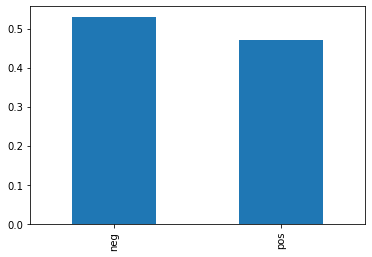

In [12]:
df_train.label_name.value_counts(normalize=True).plot(kind='bar')

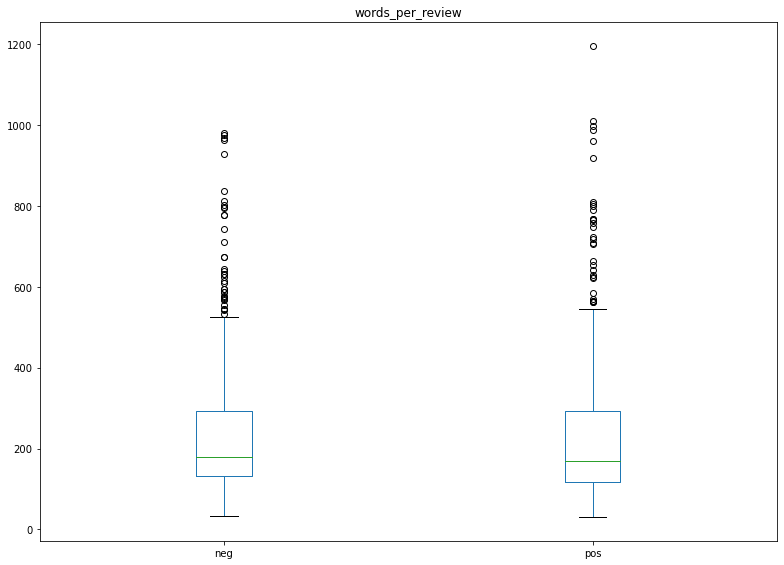

In [13]:
# Check text length
df_train['words_per_review'] = df_train.text.str.split().apply(len)
df_train.boxplot('words_per_review', by='label_name', grid=False, showfliers=True, figsize=(6.4*2, 4.8*2))
plt.suptitle('')
plt.xlabel('')
plt.show()

The majority of the reviews are shorter than DistilBERT's context size 512, with some outliers much longer.

In [14]:
train_ds.reset_format()
train_ds.format

{'type': None,
 'format_kwargs': {},
 'columns': ['text', 'label'],
 'output_all_columns': False}

## 4. Train Model

In [15]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The device available is: {device}')
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
print(f'The tokenizer\'s max input length is: {tokenizer.model_max_length}')

The device available is: cuda


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

The tokenizer's max input length is: 512


In [16]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

train_ds_encoded = train_ds.map(tokenize, batched=True, batch_size=None)
validation_ds_encoded = validation_ds.map(tokenize, batched=True, batch_size=None)
test_ds_encoded = test_ds.map(tokenize, batched=True, batch_size=None)
inference_ds_encoded = inference_ds.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [17]:
num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [18]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    #f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

"""
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
"""

'\nmetric = evaluate.load("accuracy")\n\ndef compute_metrics(eval_pred):\n    logits, labels = eval_pred\n    predictions = np.argmax(logits, axis=-1)\n    return metric.compute(predictions=predictions, references=labels)\n'

In [19]:
batch_size = 32
logging_steps = len(train_ds) // batch_size

training_args = TrainingArguments(
    output_dir='trainer_output',
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False, 
    log_level="error",
    report_to='none'
)

In [20]:
#torch.cuda.empty_cache()

trainer = Trainer(
    model=model, 
    args=training_args, 
    compute_metrics=compute_metrics,
    train_dataset=train_ds_encoded,
    eval_dataset=validation_ds_encoded,
    tokenizer=tokenizer
)

trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy
1,0.647600,0.501085,0.851000
2,0.407700,0.354949,0.868000


TrainOutput(global_step=64, training_loss=0.522305310703814, metrics={'train_runtime': 69.3497, 'train_samples_per_second': 28.839, 'train_steps_per_second': 0.923, 'total_flos': 264934797312000.0, 'train_loss': 0.522305310703814, 'epoch': 2.0})

## 5. Test Model

In [21]:
# Test using evaluator
task_evaluator = evaluator("text-classification")

results = task_evaluator.compute(
    model_or_pipeline=model,
    data=test_ds,
    tokenizer=tokenizer,
    metric="accuracy",
    label_mapping={"LABEL_0": 0.0, "LABEL_1": 1.0},
    strategy="bootstrap",
    n_resamples=10,
    random_state=0
)

pprint(results)

{'accuracy': {'confidence_interval': (0.8518313972595938, 0.8807966780098277),
              'score': 0.872,
              'standard_error': 0.008982080926922108},
 'latency_in_seconds': 0.007410971961999962,
 'samples_per_second': 134.93506723916076,
 'total_time_in_seconds': 7.410971961999962}


In [22]:
# Test using trainer's predict method
#test_ds_tokenized = test_ds.map(tokenize)
preds, labels, metrics = trainer.predict(test_ds_encoded)
pprint(metrics)

{'test_accuracy': 0.872,
 'test_loss': 0.3728659451007843,
 'test_runtime': 8.5948,
 'test_samples_per_second': 116.349,
 'test_steps_per_second': 3.723}


## 6. Save Model

In [23]:
# save the model/tokenizer
#model.save_pretrained("model")
#tokenizer.save_pretrained("tokenizer")
# load the model/tokenizer
"""
from transformers import AutoModelForTokenClassification
model = AutoModelForSequenceClassification.from_pretrained("model")
tokenizer = AutoTokenizer.from_pretrained("tokenizer")
"""

'\nfrom transformers import AutoModelForTokenClassification\nmodel = AutoModelForSequenceClassification.from_pretrained("model")\ntokenizer = AutoTokenizer.from_pretrained("tokenizer")\n'

## 7. Make Inference on New Data

In [24]:
trainer.predict(inference_ds_encoded.remove_columns('label'))

PredictionOutput(predictions=array([[-0.6449163 ,  1.0777892 ],
       [ 0.11733636,  0.1607152 ],
       [ 0.888338  , -0.61663693],
       ...,
       [ 0.3237471 , -0.0342561 ],
       [-0.3846223 ,  0.78599375],
       [-0.49401066,  0.7888224 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 8.6152, 'test_samples_per_second': 116.074, 'test_steps_per_second': 3.714})

In [25]:
text = ["I like the film it's really exciting!", "I hate the movie, it's so boring!!"]
encoding = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)
outputs = model(**encoding)
predictions = outputs.logits.argmax(-1)

In [26]:
predictions

tensor([1, 0], device='cuda:0')